In [6]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [61]:
# load the data

# load data
x_new = np.load('../../calesti-data/sequential/x_rf_60.npy') #next x_true_hr_t_sequential.npy
y_new = np.load('../../calesti-data/sequential/y_rf_60.npy')


x_new = x_new.reshape(-1, 3, int(x_new.shape[2]/3))

x_new = torch.tensor(x_new).to(torch.double)
y_new = torch.tensor(y_new).to(torch.double)

n1 = int(0.8*x_new.shape[0])
n2 = int(0.9*x_new.shape[0])
Xtr,  Ytr  = x_new[:n1], y_new[:n1]     # 80%
Xdev, Ydev = x_new[n1:n2], y_new[n1:n2]   # 10%
Xte,  Yte  = x_new[n2:], y_new[n2:]     # 10%

In [62]:
Xtr.shape, Ytr.shape

(torch.Size([5730, 3, 20]), torch.Size([5730]))

In [41]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = (torch.randn((fan_in, fan_out)) / fan_in**0.5).to(torch.double) # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]



In [42]:
torch.manual_seed(42); # seed rng for reproducibility

In [78]:
input_size = Xtr.shape[2] # the dimensionality of the character embedding vectors
n_hidden = 1000 # the number of neurons in the hidden layer of the MLP


model = Sequential([
  Linear(input_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, 1, bias=False), BatchNorm1d(1),
])

with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].gamma *= 0.1
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

23002


In [79]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  x = Xb
  for layer in layers:
    x = layer(x)
  loss = F.l1_loss(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.001 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DE

/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_929/2366212474.py:17: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(x, Yb) # loss function


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [72]:
for layer in layers:
    print(layer.__class__.__name__ ,':', tuple(layer.out.shape))

Linear : (32, 3, 200)
BatchNorm1d : (32, 3, 200)
Tanh : (32, 3, 200)
Linear : (32, 3, 1)
BatchNorm1d : (32, 3, 1)


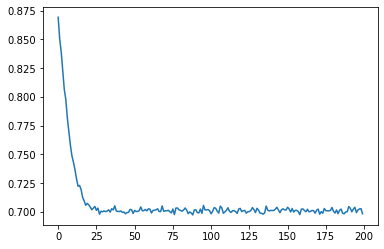

In [59]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [47]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
  layer.training = False

In [48]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    for layer in layers:
        x = layer(x)
    loss = F.l1_loss(x, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 5.061388320063971
val 4.638760370227438


/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_929/158860920.py:10: UserWarning: Using a target size (torch.Size([5730])) that is different to the input size (torch.Size([5730, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(x, y)
/var/folders/_3/x_hy8vf90v93s9rdb_r5pj140000gn/T/ipykernel_929/158860920.py:10: UserWarning: Using a target size (torch.Size([716])) that is different to the input size (torch.Size([716, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(x, y)


In [56]:
# sample from the model

x = torch.randint(2,30, (60,)).to(torch.double)
for layer in layers:
    x = layer(x)
print(x)
    
    


tensor([[8.0136]], dtype=torch.float64, grad_fn=<AddBackward0>)
